In [299]:
import numpy as np
import pandas as pd
from tqdm import tqdm 
import requests, random, string,requests, json, pickle, time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta


In [20]:
def fetch_pdb_ids(organism_taxonomy_id):
  
    pdb_ids = []
    url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": f"organism_id:{organism_taxonomy_id}",
        "format": "json",
        "size": 500  
    }
    cursor = None
    i = 0
    while i < 15:
        i+=1
        if cursor:
            # print(cursor.split('&')[0])
            params['cursor'] = cursor.split('&')[0]
            
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            
            for result in data['results']:
                temp_list = []
                for reference in result.get('uniProtKBCrossReferences', []):
                    if reference['database'] == 'PDB': 
                        if reference['id'] in pdb_ids:
                            ref_id = reference['id'] + '_' + random.choice(string.ascii_letters)
                            temp_list.append(ref_id)
                        else:
                            temp_list.append(reference['id'])
                pdb_ids.extend(temp_list)

            link_header = response.headers.get('Link')
            if link_header and 'rel="next"' in link_header:
                cursor = link_header.split('<')[1].split('>')[0].split('cursor=')[1]
            else:
                break
        else:
            print(f"Failed to fetch data: {response.status_code}")
            break

    return pdb_ids

#fetch_motifs_data function
def fetch_motifs_data(pdb_id):

    pdb_id = pdb_id.split('_')[0]
    
    
    url = 'https://data.rcsb.org/graphql'
    protein_data = pd.DataFrame({'structure': [], 'sequence':[]})
    # Model2_labels = {}
    # Model2_labels[f'{pdb_id}'] = {}

    query = f'''
    {{
      entry(entry_id: "{pdb_id}") {{
        polymer_entities {{
          rcsb_id
          entity_poly {{
            pdbx_seq_one_letter_code
          }}
          polymer_entity_instances {{
            rcsb_id
            rcsb_polymer_instance_feature {{
              type
              name
              feature_positions {{
                beg_seq_id
                end_seq_id
              }}
            }}
          }}
        }}
      }}
    }}
    '''
    
    response = requests.post(url, json={'query': query})
    
    if response.status_code == 200:   
        data = response.json()
        sequence = data['data']['entry']['polymer_entities'][0]["entity_poly"]["pdbx_seq_one_letter_code"]
        labels = np.zeros(len(sequence))           
        for i in data['data']['entry']['polymer_entities'][0]['polymer_entity_instances'][0]['rcsb_polymer_instance_feature']:
            structure = i['name']
            if structure == 'helix': 
                for j in i['feature_positions']:
                    # if len(sequence[j['beg_seq_id']-1:j['end_seq_id']])< 22:
                    protein_data.loc[len(protein_data)] = [1, sequence[j['beg_seq_id']-1:j['end_seq_id']]]
                    labels[j['beg_seq_id']-1:j['end_seq_id']] = int(1)
            if structure == 'sheet':            
                for j in i['feature_positions']:
                    # if len(sequence[j['beg_seq_id']-1:j['end_seq_id']])< 22:
                    protein_data.loc[len(protein_data)] = [2, sequence[j['beg_seq_id']-1:j['end_seq_id']]]
                    labels[j['beg_seq_id']-1:j['end_seq_id']] = int(2)

    return sequence, protein_data, labels 

def feature_engineering(pr_data):

    all_samples = pd.DataFrame({
        'pdb_id': [],
        'code': [], 
        'hydrophobicity': [], 
        'polarity':[], 
        'charge':[], 
        'mass':[], 
        'p1':[],
        'p2':[],
        'p3':[], 
        'p4':[], 
        'p5':[],
        'a1':[],
        'a2':[],
        'a3':[], 
        'a4':[], 
        'a5':[],  
        'phi_range_lower': [],
        'phi_range_upper': [],
        'psi_range_lower': [],
        'psi_range_upper': [],
        'label': []
    })

    
    for _, pr in tqdm(pr_data.iterrows(), total=pr_data.shape[0], desc="Processing proteins"):
        seq = pr['sequence']
        labels = pr['labels']
        
        t_feature = []
        seq_position_range = range(len(seq))
        
        for pos in seq_position_range:
            p1, p2, p3, p4, p5, a1, a2, a3, a4, a5 = None, None, None, None, None, None, None, None, None, None
            if pos - 1 in seq_position_range:
                p1 = seq[pos - 1]
            if pos - 2 in seq_position_range:
                p2 = seq[pos - 2]
            if pos - 3 in seq_position_range:
                p3 = seq[pos - 3]
            if pos - 4 in seq_position_range:
                p4 = seq[pos - 4]
            if pos - 5 in seq_position_range:
                p5 = seq[pos - 5]
            if pos + 1 in seq_position_range:
                a1 = seq[pos + 1]
            if pos + 2 in seq_position_range:
                a2 = seq[pos + 2]
            if pos + 3 in seq_position_range:
                a3 = seq[pos + 3]
            if pos + 4 in seq_position_range:
                a4 = seq[pos + 4]
            if pos + 5 in seq_position_range:
                a5 = seq[pos + 5]
                
            tr = Residue(seq[pos], p1, p2, p3, p4, p5, a1, a2, a3, a4, a5)
            
            all_samples.loc[len(all_samples)] = [pr['pdb_id'], tr.code, tr.hydrophobicity, tr.polarity, tr.charge, tr.mass, tr.p1, tr.p2, tr.p3, tr.p4, tr.p5, tr.a1, tr.a2, tr.a3, tr.a4,
                                            tr.a5, tr.phi_range[0], tr.phi_range[1], tr.psi_range[0], tr.psi_range[1], labels[pos]]
            
    
    return all_samples

#For prediction
def feature_transformation(sequence):
    features = pd.DataFrame({
        'code': [], 
        'hydrophobicity': [], 
        'polarity':[], 
        'charge':[], 
        'mass':[], 
        'p1':[],
        'p2':[],
        'p3':[], 
        'p4':[], 
        'p5':[],
        'a1':[],
        'a2':[],
        'a3':[], 
        'a4':[], 
        'a5':[], 
        'phi_range_lower': [],
        'phi_range_upper': [],
        'psi_range_lower': [],
        'psi_range_upper': [],
    })
    

    seq_position_range = range(len(sequence))
    
    for pos in seq_position_range:
        p1, p2, p3, p4, p5, a1, a2, a3, a4, a5 = None, None, None, None, None, None, None, None, None, None
        if pos - 1 in seq_position_range:
            p1 = sequence[pos - 1]
        if pos - 2 in seq_position_range:
            p2 = sequence[pos - 2]
        if pos - 3 in seq_position_range:
            p3 = sequence[pos - 3]
        if pos - 4 in seq_position_range:
            p4 = sequence[pos - 4]
        if pos - 5 in seq_position_range:
            p5 = sequence[pos - 5]
        if pos + 1 in seq_position_range:
            a1 = sequence[pos + 1]
        if pos + 2 in seq_position_range:
            a2 = sequence[pos + 2]
        if pos + 3 in seq_position_range:
            a3 = sequence[pos + 3]
        if pos + 4 in seq_position_range:
            a4 = sequence[pos + 4]
        if pos + 5 in seq_position_range:
            a5 = sequence[pos + 5]
            
        tr = Residue(sequence[pos], p1, p2, p3, p4, p5, a1, a2, a3, a4, a5)
        
        features.loc[len(features)] = [tr.code, tr.hydrophobicity, tr.polarity, tr.charge, tr.mass, tr.p1, tr.p2, tr.p3, tr.p4, tr.p5, tr.a1, tr.a2, tr.a3, tr.a4,
                                            tr.a5, tr.phi_range[0], tr.phi_range[1], tr.psi_range[0], tr.psi_range[1]]
        
    
    return features

    
class polypeptide:
    
    def __init__(self, pdb_id, labels):
        self.pdb_id = pdb_id
        self.random_coils, self.helices, self.sheets = self.find_motifs_range(labels)
        self.labels = labels

    def find_motifs_range(self, sequence):
        
        helices_range = []
        sheets_range = []
        random_coils_range = []
        
        start = 0
        
        for i in range(1, len(sequence)):
            
            if sequence[i] != sequence[i - 1]:  
                if sequence[start] == 0:
                    random_coils_range.append((start, i ))
                elif sequence[start] == 1:
                    helices_range.append((start, i))
                elif sequence[start] == 2:
                    sheets_range.append((start, i))
                start = i  
            
        if sequence[start] == 0:
            random_coils_range.append((start, len(sequence) ))
        elif sequence[start] == 1:
            helices_range.append((start, len(sequence)))
        elif sequence[start] == 2:
            sheets_range.append((start, len(sequence)))
        
        return random_coils_range, helices_range, sheets_range


class Residue:
    def __init__(self, code, p1 = None, p2 = None, p3 = None, p4 = None, p5 = None, a1 = None, a2 = None, a3 = None, a4 = None, a5 = None):
        self.code = code
        self.hydrophobicity = self.get_hydrophobicity()
        self.polarity = self.get_polarity()
        self.charge = self.get_charge()
        self.mass = self.get_mass()
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
        self.p4 = p4
        self.p5 = p5
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.a4 = a4
        self.a5 = a5
        self.phi_range = self.get_phi_range()
        self.psi_range = self.get_psi_range()
    

    def get_hydrophobicity(self):
        # Based on Kyte-Doolittle
        hydrophobicity_scale = {
            'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
            'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
            'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
            'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
        }
        return hydrophobicity_scale.get(self.code, 0)

    def get_polarity(self):
        polarity_scale = {
            'A': 'nonpolar', 'C': 'polar', 'D': 'polar', 'E': 'polar', 'F': 'nonpolar',
            'G': 'nonpolar', 'H': 'polar', 'I': 'nonpolar', 'K': 'polar', 'L': 'nonpolar',
            'M': 'nonpolar', 'N': 'polar', 'P': 'nonpolar', 'Q': 'polar', 'R': 'polar',
            'S': 'polar', 'T': 'polar', 'V': 'nonpolar', 'W': 'nonpolar', 'Y': 'polar'
        }
        return polarity_scale.get(self.code, 'unknown')

    def get_charge(self):
        charge_scale = {
            'A': 'neutral', 'C': 'neutral', 'D': 'negative', 'E': 'negative', 'F': 'neutral',
            'G': 'neutral', 'H': 'positive', 'I': 'neutral', 'K': 'positive', 'L': 'neutral',
            'M': 'neutral', 'N': 'neutral', 'P': 'neutral', 'Q': 'neutral', 'R': 'positive',
            'S': 'neutral', 'T': 'neutral', 'V': 'neutral', 'W': 'neutral', 'Y': 'neutral'
        }
        return charge_scale.get(self.code, 'unknown')

    def get_mass(self):
        mass_scale = {
            'A': 89.1, 'C': 121.2, 'D': 133.1, 'E': 147.1, 'F': 165.2,
            'G': 75.1, 'H': 155.2, 'I': 131.2, 'K': 146.2, 'L': 131.2,
            'M': 149.2, 'N': 132.1, 'P': 115.1, 'Q': 146.2, 'R': 174.2,
            'S': 105.1, 'T': 119.1, 'V': 117.1, 'W': 204.2, 'Y': 181.2
        }
        return mass_scale.get(self.code, 0.0)

    def get_phi_range(self):
        phi_range_data = {
            'G': [-180, 180], 'P': [-60, -80], 'A': [-60, -90],
            'V': [-110, -140], 'L': [-70, -90], 'I': [-110, -140],
            'F': [-60, -90], 'Y': [-60, -90], 'W': [-60, -90],
            'S': [-60, -120], 'T': [-100, -140], 'C': [-60, -90],
            'M': [-60, -90], 'D': [-60, -120], 'E': [-60, -120],
            'K': [-60, -120], 'R': [-60, -120], 'H': [-60, -120],
            'N': [-60, -120], 'Q': [-60, -120]
        }
        return phi_range_data.get(self.code, [0, 0])

    def get_psi_range(self):
        psi_range_data = {
            'G': [-180, 180], 'P': [-40, 50], 'A': [-30, 30],
            'V': [120, 150], 'L': [-30, 30], 'I': [120, 150],
            'F': [-30, 30], 'Y': [-30, 30], 'W': [-30, 30],
            'S': [-20, 20], 'T': [120, 150], 'C': [-30, 30],
            'M': [-30, 30], 'D': [-20, 20], 'E': [-20, 20],
            'K': [-20, 20], 'R': [-20, 20], 'H': [-20, 20],
            'N': [-20, 20], 'Q': [-20, 20]
        }
        return psi_range_data.get(self.code, [0, 0])



In [6]:
#Data Mining

pdb_ids = fetch_pdb_ids('562')
pdb_ids = pd.DataFrame({'id': pdb_ids})

motif_data = pd.DataFrame({'structure': [], 'sequence':[], 'pdb_id': []})
pr_sequences = pd.DataFrame({'pdb_id': [], 'labels': [], 'sequence': []})
with tqdm(range(len(pdb_ids['id'])), desc = 'Completion: ', ncols = 120) as pbar:
    for i in pbar:
        idid = pdb_ids['id'].iloc[i]
        seq, database, labels = fetch_motifs_data(idid)
        database['pdb_id'] = idid
        labels_temp_DF = pd.DataFrame({'pdb_id': idid, 'sequence': seq, 'labels':[labels]})
        motif_data = pd.concat([motif_data, database])
        pr_sequences = pd.concat([pr_sequences, labels_temp_DF])
        globals()[idid] = polypeptide(idid, labels)
motif_data.reset_index(drop=True, inplace=True) 



Completion: 100%|███████████████████████████████████████████████████████████████████| 1334/1334 [05:17<00:00,  4.20it/s]


In [21]:
#Data preprocessing

#Cleaning dataset
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
pr_sequences = pr_sequences[pr_sequences['sequence'].apply(lambda x: all(char in amino_acids for char in x))]
pr_sequences.reset_index(drop=True, inplace=True)

for ind in pr_sequences.index:
    labels = pr_sequences['labels'].iloc[ind]
    idid = pr_sequences['pdb_id'].iloc[ind]
    globals()[idid] = polypeptide(idid, labels)

motif_data = motif_data[motif_data['sequence'].apply(lambda x: any(char in amino_acids for char in x))]
motif_data.reset_index(drop=True, inplace=True)

#Transforming the initial dataset by extracting features required to train a random forest model!
transformed_data = feature_engineering(pr_sequences)

#Converting categorical columns to one hot encoded columns
transformed_data_one_hot_encoded = pd.get_dummies(transformed_data, columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'a1', 'a2', 'a3', 'a4', 'a5', 'code', 'polarity', 'charge'])


Processing proteins: 100%|████████████████| 1201/1201 [1:15:19<00:00,  3.76s/it]


In [175]:

#Splitting the dataset to training and testing datasets
X = transformed_data_one_hot_encoded.drop(columns=['pdb_id', 'label'])
y = transformed_data_one_hot_encoded['label'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

#Training the model
rf_model = RandomForestClassifier( n_estimators = 150, max_depth = 50, max_features = 'sqrt', bootstrap = True, random_state = 42, n_jobs = -1)
rf_model.fit(X_train, y_train)





RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1,
                       random_state=42)

Accuracy: 0.9388591185550966

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92     94623
           1       0.93      0.97      0.95    109882
           2       0.95      0.96      0.95     33241

    accuracy                           0.94    237746
   macro avg       0.94      0.94      0.94    237746
weighted avg       0.94      0.94      0.94    237746


Top 10 Important Features:
              feature  importance
0     hydrophobicity    0.019411
1               mass    0.015239
11              p1_G    0.008798
115             a1_L    0.008151
138             a2_P    0.007970
118             a1_P    0.007945
135             a2_L    0.007813
3    phi_range_upper    0.007792
35              p2_L    0.007686
175             a4_L    0.007571


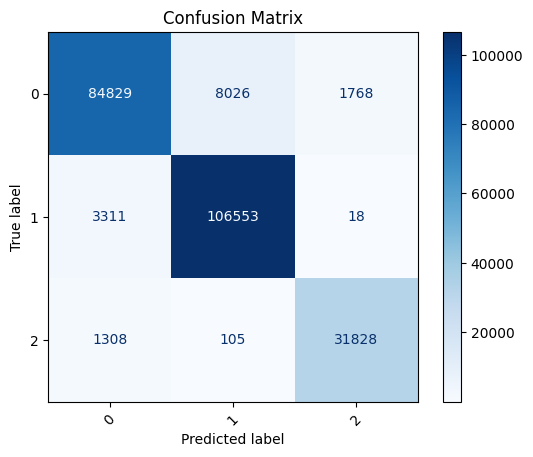

In [176]:
#Prediction on the train dataset:
y_pred_train = rf_model.predict(X_train)

#Evaluation:
    #Total Accuracy:
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

feature_importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
feature_importances = feature_importances.sort_values(by = 'importance', ascending = False)
print("\nTop 10 Important Features:\n", feature_importances.head(10))

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


Accuracy: 0.8771306575576431

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85     46781
           1       0.87      0.93      0.90     54335
           2       0.90      0.81      0.86     15984

    accuracy                           0.88    117100
   macro avg       0.88      0.86      0.87    117100
weighted avg       0.88      0.88      0.88    117100


Top 10 Important Features:
              feature  importance
0     hydrophobicity    0.019411
1               mass    0.015239
11              p1_G    0.008798
115             a1_L    0.008151
138             a2_P    0.007970
118             a1_P    0.007945
135             a2_L    0.007813
3    phi_range_upper    0.007792
35              p2_L    0.007686
175             a4_L    0.007571


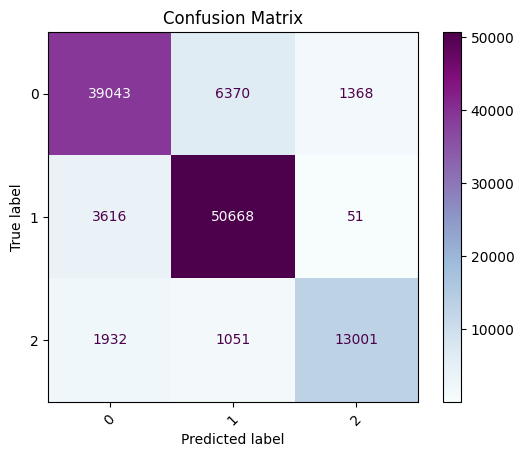

In [318]:
#Prediction on the test dataset:
y_pred_test = rf_model.predict(X_test)

#Evaluation:
    #Total Accuracy:
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

feature_importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
feature_importances = feature_importances.sort_values(by = 'importance', ascending = False)
print("\nTop 10 Important Features:\n", feature_importances.head(10))

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap="BuPu", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.savefig('confMat.pdf', dpi = 300)
plt.show()


In [332]:
#For prediction

def submit_blast(sequence, database):
    url = "https://blast.ncbi.nlm.nih.gov/Blast.cgi"
    params = {
        "CMD": "Put",
        "PROGRAM": "blastp",
        "DATABASE": database,
        "QUERY": sequence
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        response_text = response.text
        rid_line = next(line for line in response_text.splitlines() if "RID =" in line)
        return rid_line.split("=")[1].strip() 
    else:
        raise Exception(f"Error submitting BLAST job: {response.status_code} {response.text}")

def check_blast_status(rid):
    url = "https://blast.ncbi.nlm.nih.gov/Blast.cgi"
    params = {"CMD": "Get", "RID": rid}
    response = requests.get(url, params=params)
    if "Status=WAITING" in response.text:
        return "WAITING"
    elif "Status=FAILED" in response.text:
        return "FAILED"
    elif "Status=UNKNOWN" in response.text:
        return "UNKNOWN"
    else:
        return "FINISHED"

def retrieve_blast_results(rid, format_type="XML"):
    url = "https://blast.ncbi.nlm.nih.gov/Blast.cgi"
    params = {"CMD": "Get", "RID": rid, "FORMAT_TYPE": format_type}
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Error retrieving BLAST results: {response.status_code} {response.text}")

def parse_exact_matches(xml_results, query_sequence):
    root = ET.fromstring(xml_results)
    exact_matches = []
    for hit in root.findall(".//Hit"):
        for hsp in hit.findall(".//Hsp"):

            hsp_identity = int(hsp.find("Hsp_identity").text)
            hsp_align_len = int(hsp.find("Hsp_align-len").text)
            hsp_qseq = hsp.find("Hsp_qseq").text  
            hsp_hseq = hsp.find("Hsp_hseq").text 
            if hsp_qseq == query_sequence and hsp_hseq == query_sequence and hsp_identity == hsp_align_len:
                hit_id = hit.find("Hit_id").text
                exact_matches.append(hit_id)
    return exact_matches

def lets_predict(model, actual_structure = True):

    colors = ["#003f5c", "#bc5090", "#ffa600"]
    cmap = np.array(colors)
    
    model_feature_list = list(model.feature_names_in_)
    sequence_input = input('Enter the amino acid sequence of your polypeptide: ')
    sequence_input = sequence_input.replace(" ", "")

    pdb_id = None
    if actual_structure == True:
        try:
            rid = submit_blast(sequence_input, 'pdb')
            print(f"Searching for the structure in PDB database!")
            
            status = check_blast_status(rid)
            while status == "WAITING":
                time.sleep(30)
                print(f"Still searching! Next update at {(datetime.now()+ timedelta(seconds = 30)).strftime('%H:%M:%S')}")
                status = check_blast_status(rid)
            if status == "FINISHED":
                print("Job finished. Retrieving results...")
                xml_results = retrieve_blast_results(rid, format_type = "XML")
                matches = parse_exact_matches(xml_results, sequence_input)
                if matches:
                    pdb_id = matches[0].split('|')[1]
                else:
                    print("No exact matches found.")
            else:
                print("No structure found!")
        
        except Exception as e:
            print(f"Error: {e}")
    
    if pdb_id:
        seqq, _, true_labels = fetch_motifs_data(pdb_id)
        plt.figure(figsize = (10, 1))
        for i in range(len(true_labels)):
            plt.bar(i, 1, color = cmap[int(true_labels[i])], edgecolor = 'none')
        plt.title(f'Actual Structure')
        plt.axis('off')
        
        
    
    X = feature_transformation(sequence_input)
    X = pd.get_dummies(X, columns = ['p3', 'p4', 'p5', 'a3', 'a4', 'a5', 'code', 'polarity', 'charge'])
    features_not_in_dataset = set(model_feature_list).difference(set(X.columns))
    new_columns = pd.DataFrame({feature: False for feature in features_not_in_dataset}, index = X.index)
    X = pd.concat([X, new_columns], axis = 1)
    X = X[model_feature_list]
    predicted_labels = model.predict(X)
    
    plt.figure(figsize = (10, 1))
    for i in range(len(predicted_labels)):
        plt.bar(i, 1, color = cmap[int(predicted_labels[i])], edgecolor = 'none')
    plt.title('Predicted Structure')
    plt.axis('off')

    helices_patch = mpatches.Patch(color = '#bc5090', label = r'$\alpha$-helices')
    random_coils_patch = mpatches.Patch(color = '#003f5c', label = 'random coils')
    sheets_patch = mpatches.Patch(color = '#ffa600', label = r'$\beta$-sheets')
    plt.legend(handles=[helices_patch, random_coils_patch, sheets_patch],loc = 'upper center', bbox_to_anchor = (0.5, -0.1), ncol = 2)




    return 



Enter the amino acid sequence of your polypeptide:  HPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRIDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPVAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW


Searching for the structure in PDB database!
Still searching! Next update at 18:10:04
Still searching! Next update at 18:10:35
Still searching! Next update at 18:11:05
Still searching! Next update at 18:11:35
Still searching! Next update at 18:12:06
Job finished. Retrieving results...


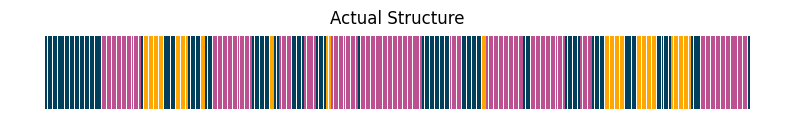

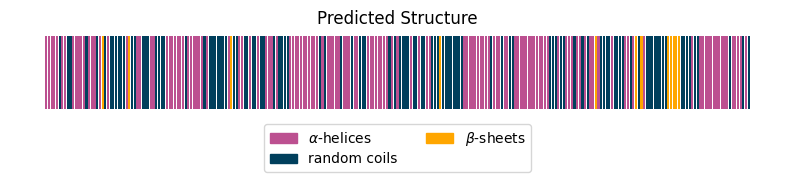

In [334]:
lets_predict(rf_model, actual_structure = True)

In [333]:
pr_sequences.iloc[8]['sequence']

'HPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRIDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPVAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'